In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial

In [83]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [3]:
def plot_dlrho(dlkymo_rho, edt, rs, pos, fluo_chns,t0):
    wdlkymo_rho = np.zeros_like(dlkymo_rho)
    nt, _ = dlkymo_rho.shape
    
    if fluo_chns == 3:
        for c in range(fluo_chns-1):
            wdlkymo_rho[:,:,c] = warp(dlkymo_rho[:,:,c], map_edt, {'edt':edt, 'rs':rs})
        wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
        
        plt.figure(figsize=(7,2))
        plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,1],wdlkymo_rho[t0:,:,1]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)

    else:
        wdlkymo_rho[:,:] = warp(dlkymo_rho[:,:], map_edt, {'edt':edt, 'rs':rs})
        wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
        
        plt.figure(figsize=(7,2))
        #plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1],wdlkymo_rho[t0:,:]]).transpose(), 
                aspect='auto', 
                extent=[t0,nt,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)

In [2]:
def map_edt(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [7]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#scope_name = 'Tweez scope'

#path_scope = os.path.join(path_ext, scope_name)
#path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}


In [6]:
#exp_date = '2023_11_15'
#scope_name = 'Ti scope'
#vector = 'pLPT20&pLPT41'

In [7]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [8]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Notebooks/Positions.xlsx')
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-11-15,Ti scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-5),2023_11_15
1,2023-11-15,Tweez scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-6),2023_11_15
2,2023-11-17,Ti scope,DHL708,pLPT119&pLPT41,-,10^(-5),2023_11_17
3,2023-11-17,Tweez scope,MC4100 & DHL708,pLPT119&pLPT41,-,10^(-6),2023_11_17
4,2023-11-28,Ti scope,MC4100 & MG1655,pAAA,-,10^(-6),2023_11_28
5,2023-11-28,Tweez scope,MG1655,pAAA,-,10^(-5),2023_11_28
6,2023-11-30,Ti scope,MC4100,pAAA,-,10^(-6),2023_11_30
7,2023-11-30,Tweez scope,MC4100,pAAA,-,10^(-5),2023_11_30
8,2023-12-04,Ti scope,MC4100,pLPT107&pLPT41,IPTG,10^(-6),2023_12_04
9,2023-12-04,Tweez scope,MC4100,pLPT107&pLPT41,IPTG,10^(-5),2023_12_04


In [174]:
#for i in exp_sum.index.values:
#exp_date = exp_sum.loc[i,'formatted_dates']
#vector = exp_sum.loc[i,'DNA']
#scope_name = exp_sum.loc[i,'Machine']
"""
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
    (positions.DNA == vector) & 
    (positions.Machine == scope_name) & 
    (positions.Quality == 'Very good')]
poss = df_pos.Position.unique()
poss
"""

"\ndf_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & \n    (positions.DNA == vector) & \n    (positions.Machine == scope_name) & \n    (positions.Quality == 'Very good')]\nposs = df_pos.Position.unique()\nposs\n"

#### Wave speed computation

Pos 0
2023_12_04_Ti_pLPT107&pLPT41
t0: 75, tf: 215


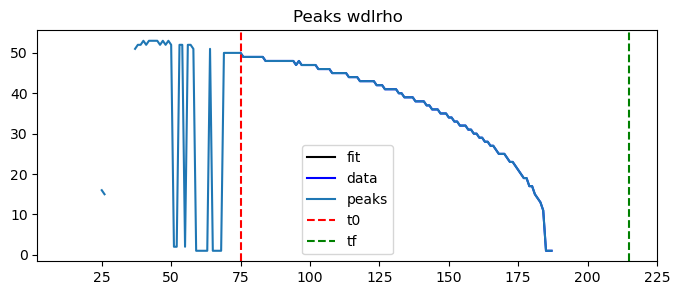

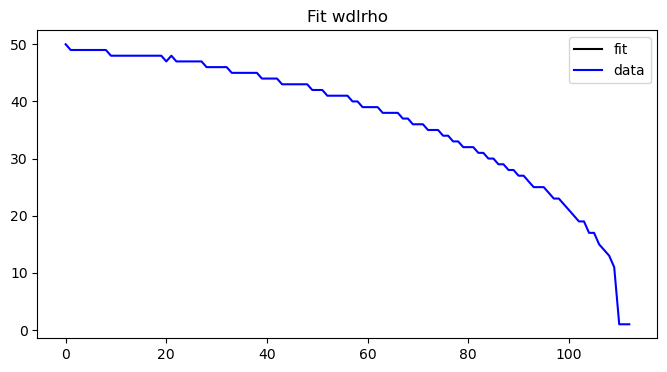

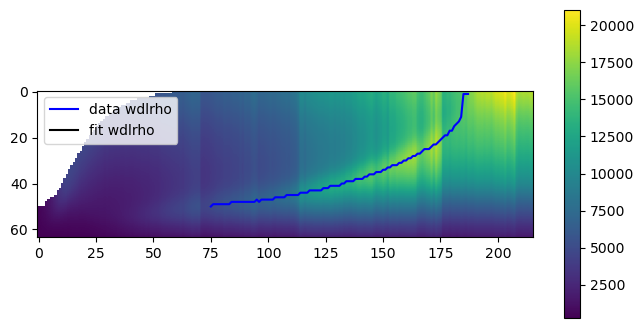

Pos 2
2023_12_04_Ti_pLPT107&pLPT41
t0: 75, tf: 215


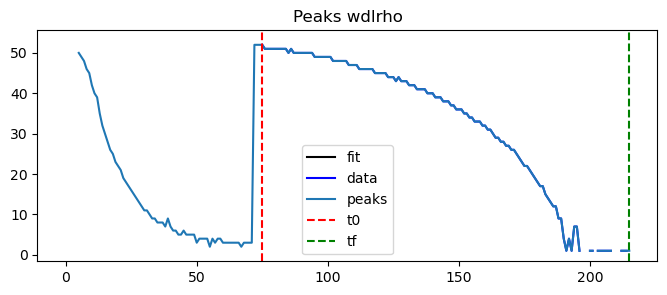

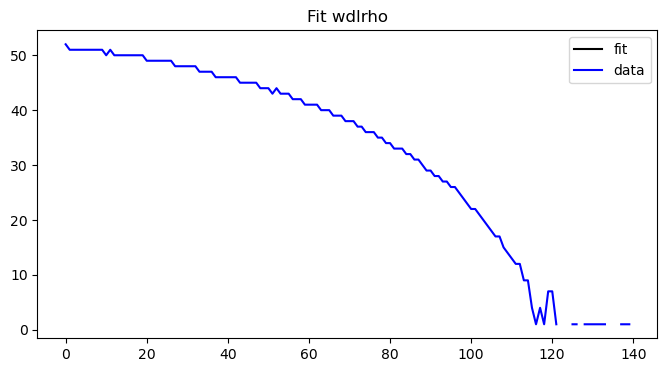

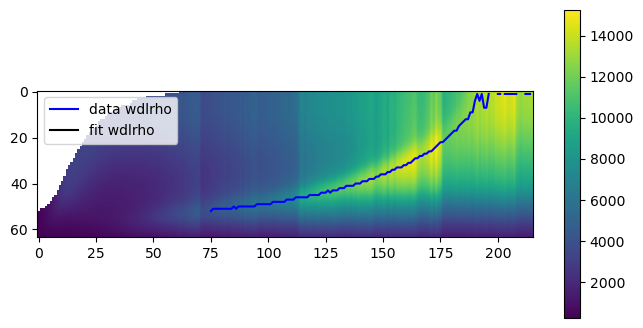

Pos 3
2023_12_04_Ti_pLPT107&pLPT41
t0: 70, tf: 215


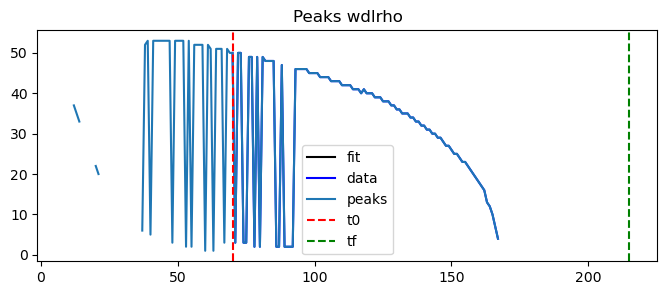

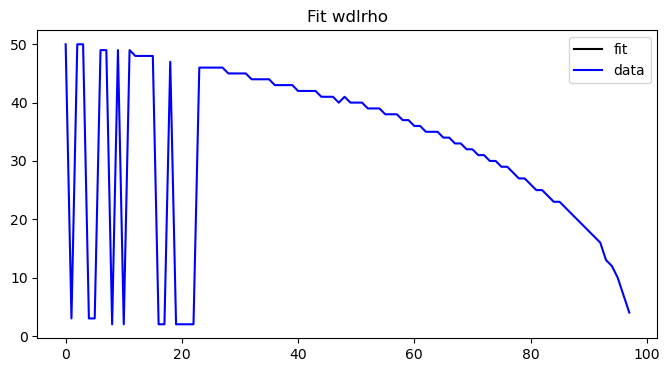

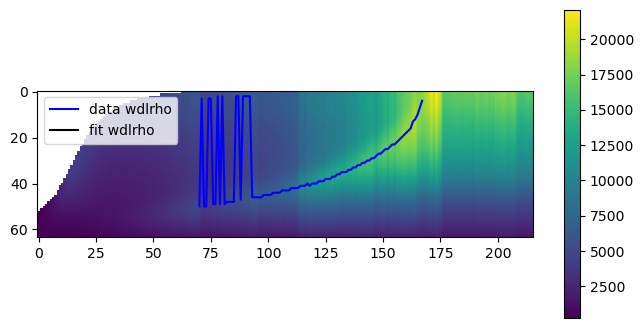

Pos 9
2023_12_04_Ti_pLPT107&pLPT41
t0: 55, tf: 215


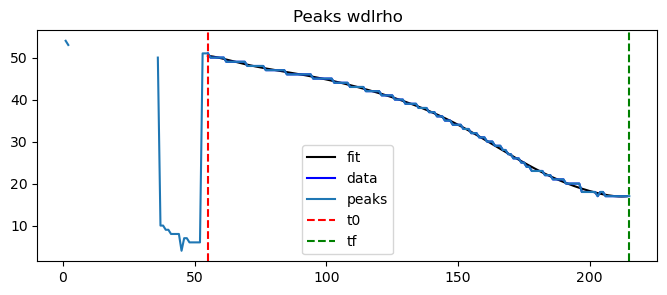

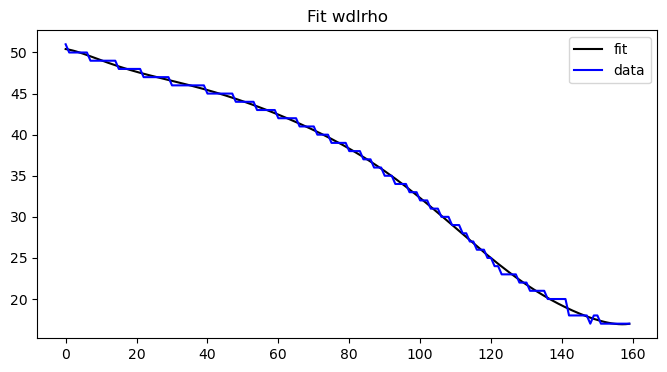

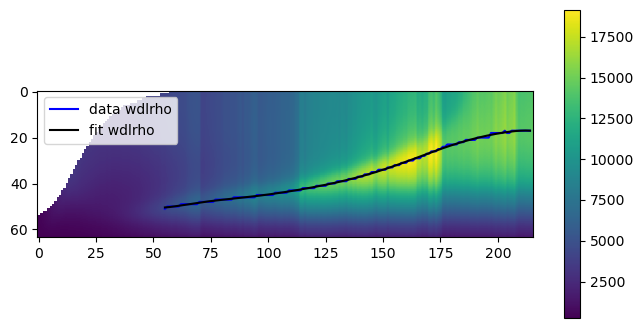

Pos 10
2023_12_04_Ti_pLPT107&pLPT41
t0: 55, tf: 215


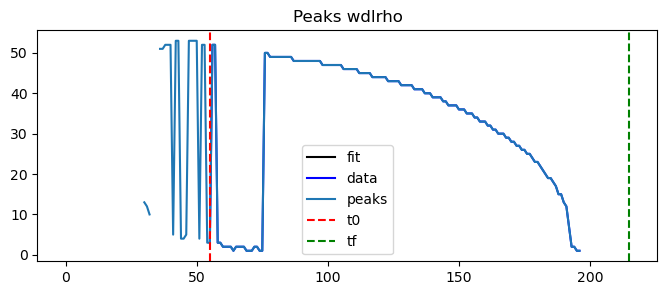

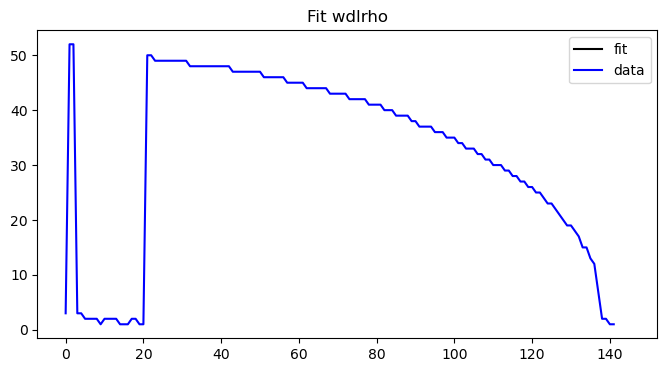

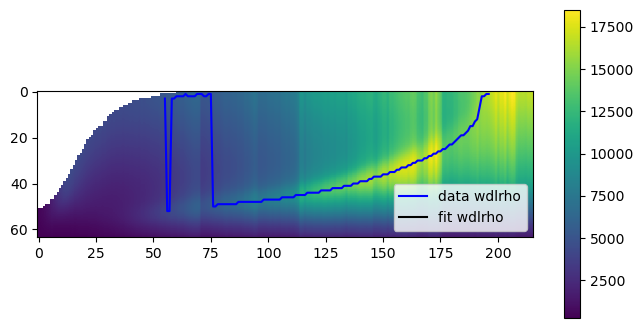

Pos 11
2023_12_04_Ti_pLPT107&pLPT41
t0: 55, tf: 215


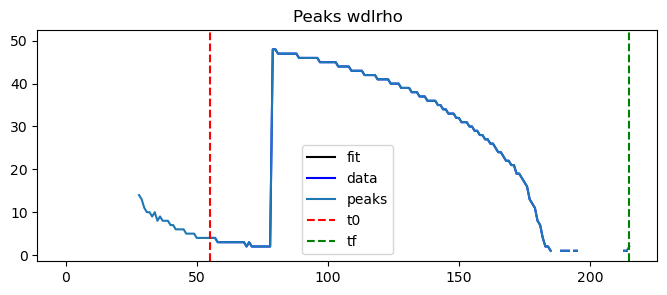

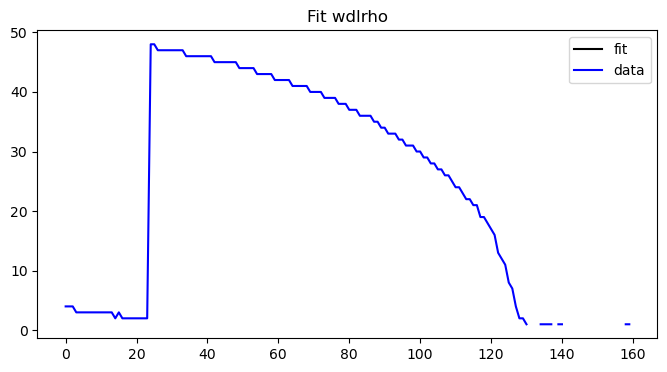

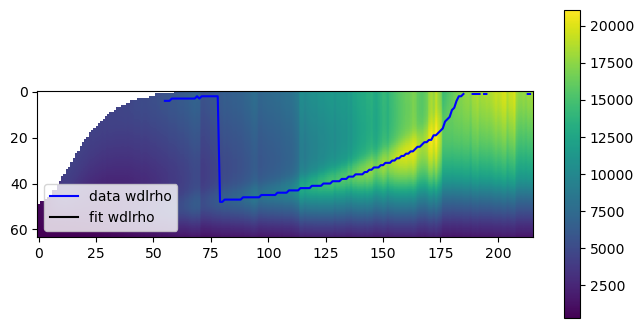

Pos 14
2023_12_04_Ti_pLPT107&pLPT41
t0: 75, tf: 215


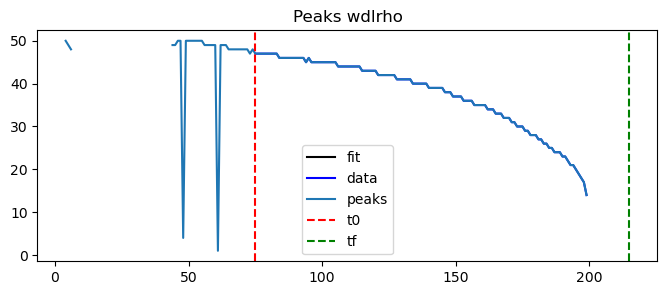

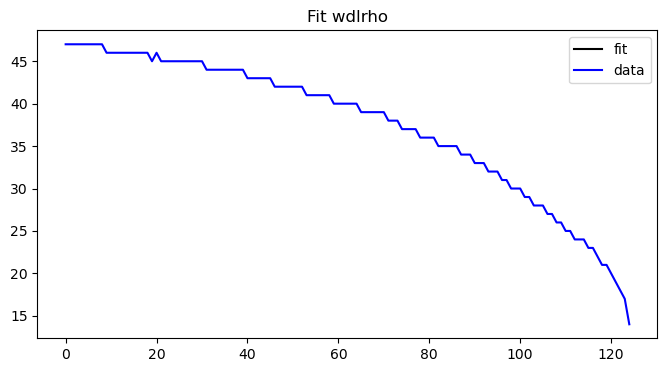

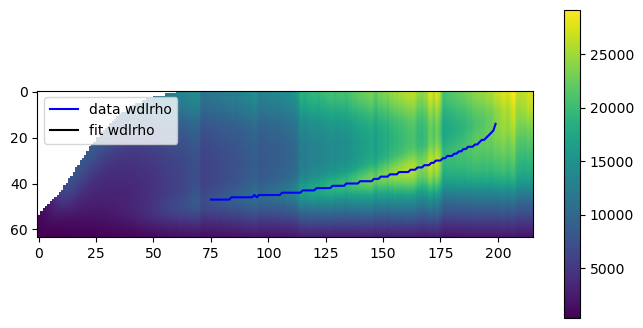

Pos 15
2023_12_04_Ti_pLPT107&pLPT41
t0: 128, tf: 215


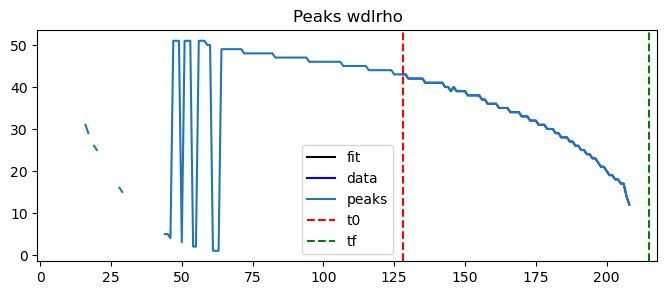

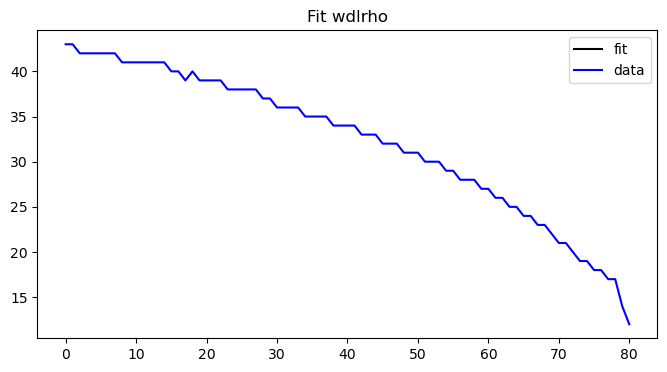

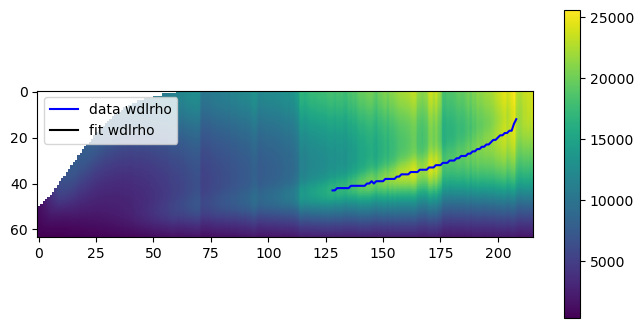

Pos 18
2023_12_04_Ti_pLPT107&pLPT41
t0: 135, tf: 215


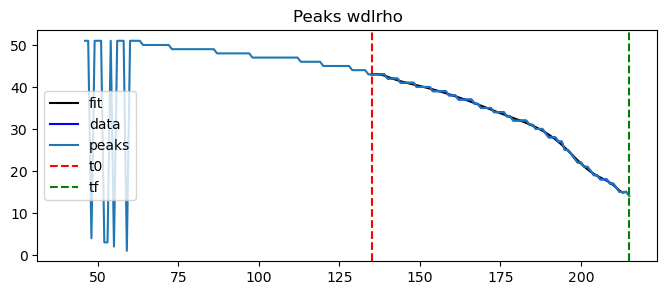

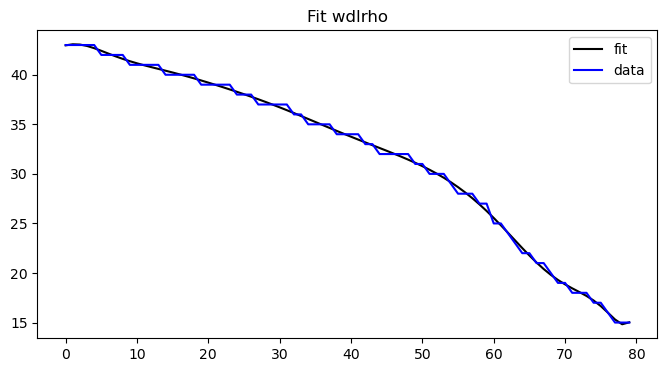

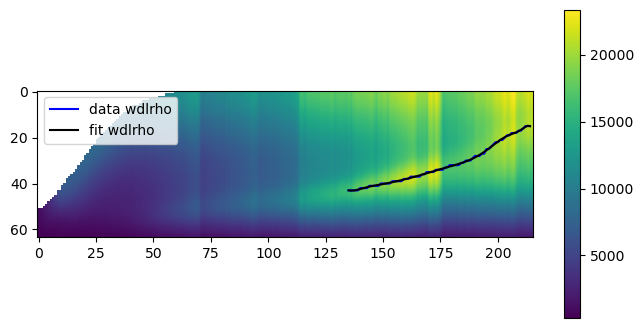

Pos 19
2023_12_04_Ti_pLPT107&pLPT41
t0: 55, tf: 215


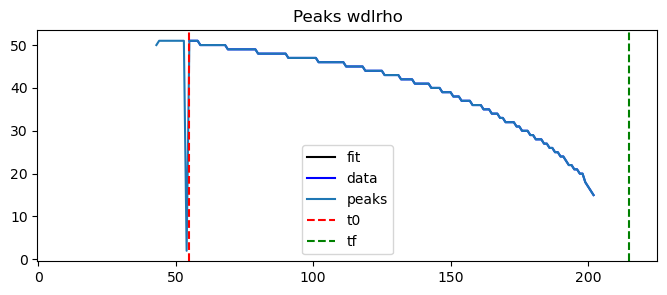

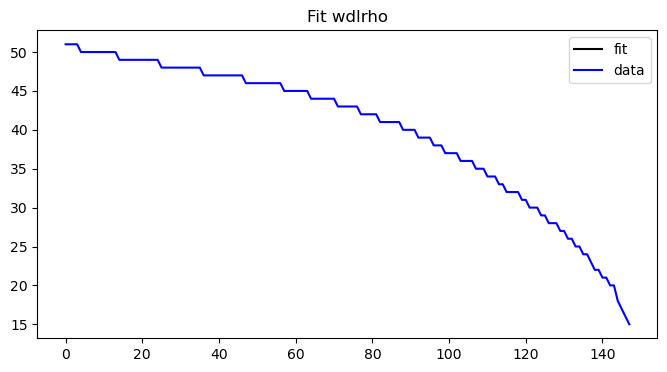

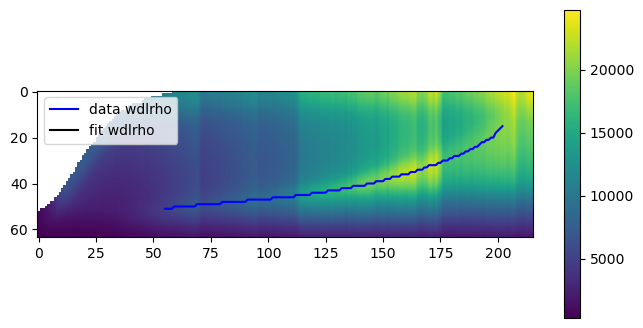

Pos 21
2023_12_04_Ti_pLPT107&pLPT41
t0: 125, tf: 215


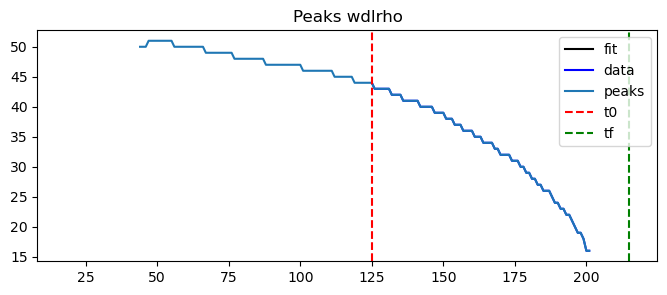

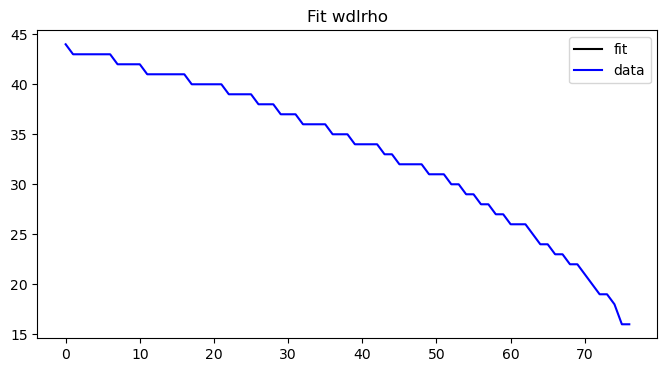

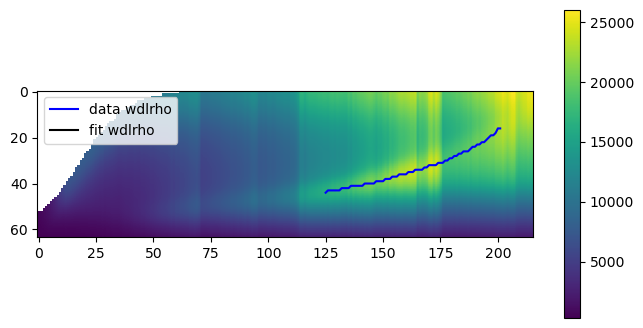

Pos 22
2023_12_04_Ti_pLPT107&pLPT41
t0: 50, tf: 215


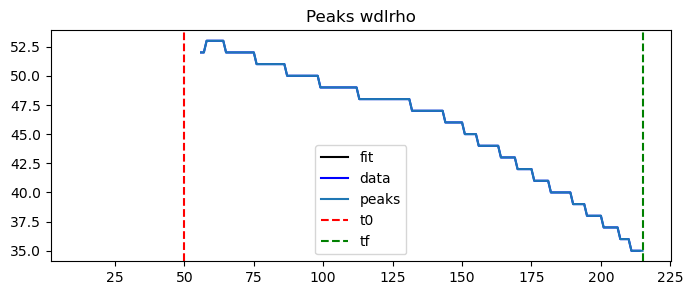

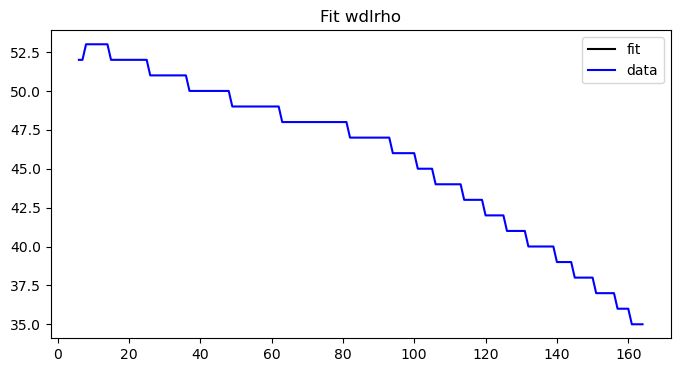

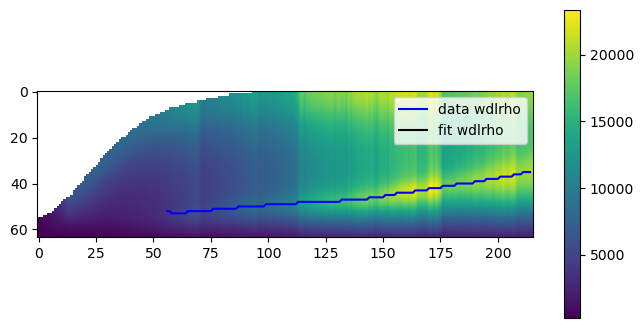

Pos 24
2023_12_04_Ti_pLPT107&pLPT41
t0: 50, tf: 215


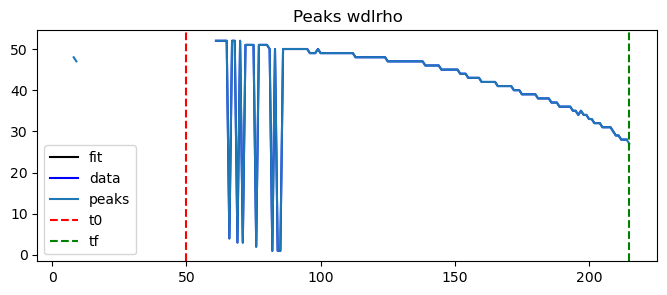

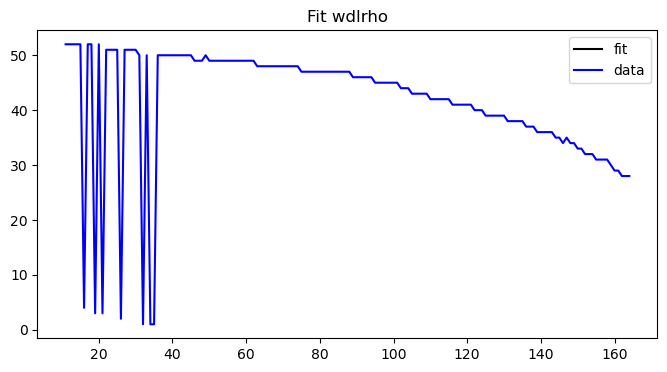

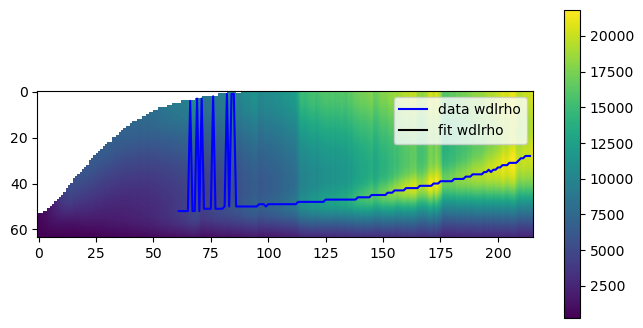

Pos 26
2023_12_04_Ti_pLPT107&pLPT41
t0: 50, tf: 215


/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


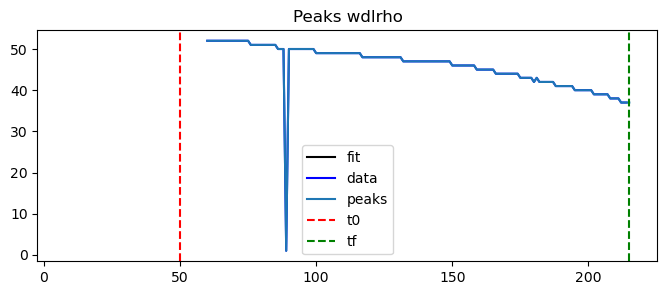

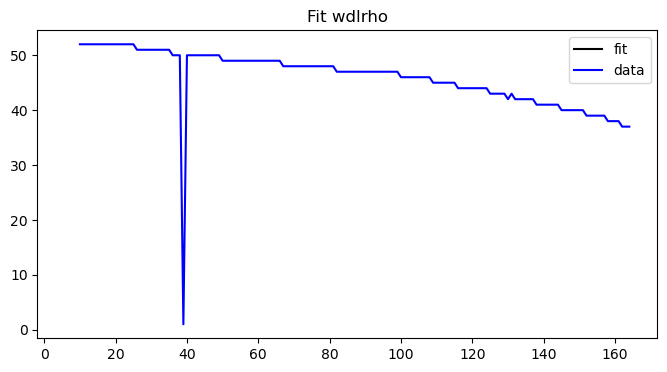

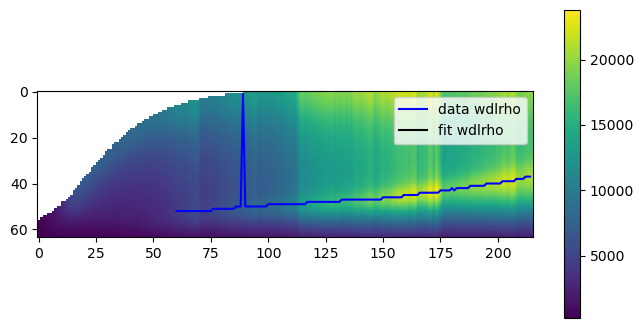

Pos 28
2023_12_04_Ti_pLPT107&pLPT41
t0: 50, tf: 215


/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


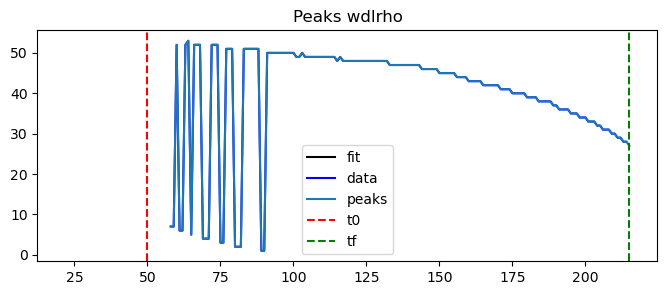

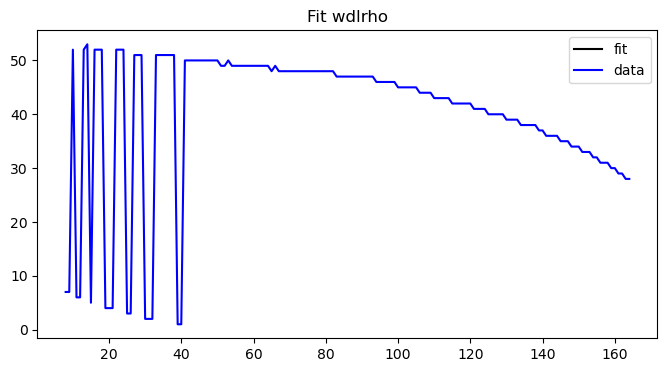

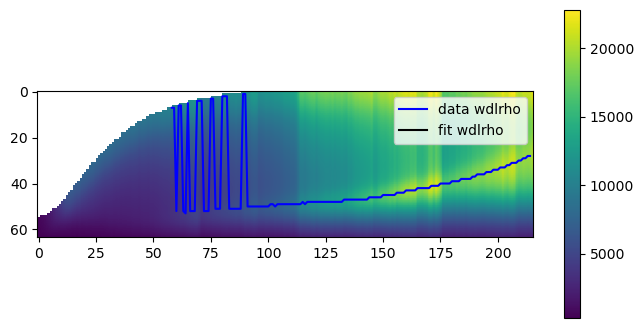

In [178]:
df = pd.read_excel('../Notebooks/data_processed.xlsx')
df.loc[:,['wave_pos_coefs']] = pd.Series(dtype='object')
for i in [8]:#exp_sum.index.values:
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    df_pos_all = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
    poss = df_pos_all.Position.unique()
    if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
        yfp_chn = 0
        cfp_chn = 1
        ph_chn = 2
        fluo_chns = 2
    else:
        rfp_chn = 0
        yfp_chn = 1
        cfp_chn = 2
        ph_chn = 3
        fluo_chns = 3
    
    for pos in poss:
        print(f"Pos {pos}")
        print(f"{exp_date}_{scopes[scope_name]}_{vector}")
        path_scope = os.path.join(path_ext, scope_name)
        path = os.path.join(path_scope, exp_date)
        path_results = os.path.join(path, folder_results, f"pos{pos}")
        df_pos = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) & 
            (df.Machine == scope_name) & 
            (df.Position == pos)]
        df_idx = df_pos.index[0]

        delta = df_pos['Delta used'].values[0]
        if delta == 'yc' and fluo_chns == 2:
            delta_idx = 0
        elif delta == 'yc' and fluo_chns == 3:
            delta_idx = 2
        elif delta == 'ry':
            delta_idx = 0
        
        if pd.notna(df.loc[df_idx, 'time_wave_start']):
            t0 = int(df.loc[df_idx, 'time_wave_start'])
            tf = int(df.loc[df_idx, 'time_wave_arrival'])
            degree = int(df.loc[df_idx, 'degree'])
            
            print(f"t0: {t0}, tf: {tf}")

            ## Peaks wdlrho
            
            wdlkymo_rho = np.load(os.path.join(path_results,'wdlkymo_rho.npy'))
            nt, nr, _ = wdlkymo_rho.shape
            data = wdlkymo_rho[:,::-1,delta_idx].transpose()            
            rads = np.zeros(nt)
            for t in range(nt):
                peaks, _ = find_peaks(data[:,t])
                try:
                    idx = np.argsort(data[peaks,t])[-1]
                    rads[t] = peaks[idx]
                except:
                    rads[t] = np.nan    

            ## Fit wdlkymo
            wave_pos_coefs = np.polyfit(np.arange(len(rads[t0:tf])), rads[t0:tf], degree)
            wave_pos_fit = np.polyval(wave_pos_coefs, np.arange(len(rads[t0:tf])))
            
            wave_vel_coefs = np.polyder(wave_pos_coefs)
            wave_vel_fit = np.polyval(wave_vel_coefs, np.arange(len(rads[t0:tf])))

            
            edt = np.load(os.path.join(path_results,'edt.npy'))
            edt0 = edt[-1]
            edt_max = edt0.max() # max rad
            bin_min = savgol_filter(wave_pos_fit, 21, 3,deriv=1) / 10 ##  bins per minute
            px_bin = edt_max / 64 # pixel per bin
            um_px = df_pos['um_px'].values[0]
    
            ## in um/h
            wave_speed_av = bin_min.mean() * px_bin * um_px * 60
            df.at[df_idx, 'wave_speed_av'] = wave_speed_av
            df.at[df_idx, 'wave_pos_coefs'] = wave_pos_coefs

            print(wave_speed_av)
           
            """
            ## peaks wdlrho
            plt.figure(figsize=(8,3))
            plt.plot(np.arange(t0,t0+len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
            plt.plot(np.arange(t0,t0+len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
            plt.plot(rads, label='peaks')
            plt.axvline(x=t0, color='r', linestyle='--', label='t0')
            plt.axvline(x=tf, color='g', linestyle='--', label='tf')
            plt.title('Peaks wdlrho')
            plt.legend()
            #pdf_file.savefig() 
            #plt.close()
            plt.show()

            ## fit wdlrho
            plt.figure(figsize=(8,4))
            plt.plot(np.arange(len(rads[t0:tf])),wave_pos_fit, color='k',label='fit')
            plt.plot(np.arange(len(rads[t0:tf])), rads[t0:tf], color='b', label='data')
            plt.title('Fit wdlrho')
            plt.legend()
            #pdf_file.savefig() 
            #plt.close()
            plt.show()
            
            plt.figure(figsize=(8,4))            
            plt.imshow(data)
            plt.plot(np.arange(t0,tf), rads[t0:tf], color='b', label='data wdlrho')
            plt.plot(np.arange(t0,tf),wave_pos_fit, color='k',label='fit wdlrho')
            plt.legend()
            plt.legend()
            #plt.colorbar()
            #pdf_file.savefig() 
            #plt.close()
            plt.colorbar()
            plt.show()
            """

In [259]:
df = pd.read_excel('../Notebooks/data_processed.xlsx')


In [260]:
plot_data = df.groupby('Dilution').agg({
    'wave_speed_av': ['mean', 'std'],
    'Pad': 'size'
}).reset_index()
plot_data

Dilution wave_speed_av            Pad
                    mean       std size
0  10^(-5)     11.107852  3.467710  130
1  10^(-6)      7.317441  3.839086   30

In [269]:
fig, ax = plt.subplots(figsize=(10, 6))
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

max_tm = plot_data['wave_speed_av']['mean'] + plot_data['wave_speed_av']['std']
global_max = max_tm.max()

for idx, row in plot_data.iterrows():
    ax.bar(idx, row['wave_speed_av']['mean'], yerr=row['wave_speed_av']['std'], capsize=5, color=area_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['wave_speed_av']['mean']/2, str(row['Pad']['size']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Wave speed per dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel(r'Average wave speed $\mu m/h$')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

NameError: name 'mean_std_area_per_pad_dilution' is not defined

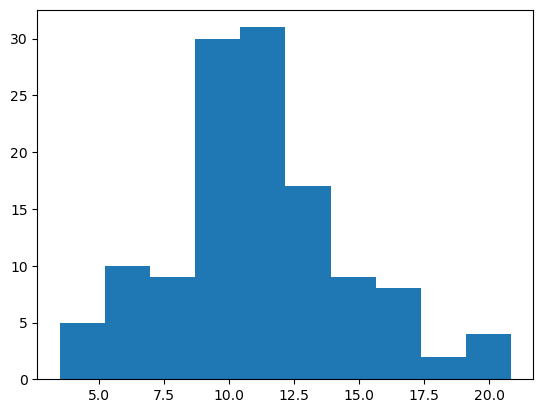

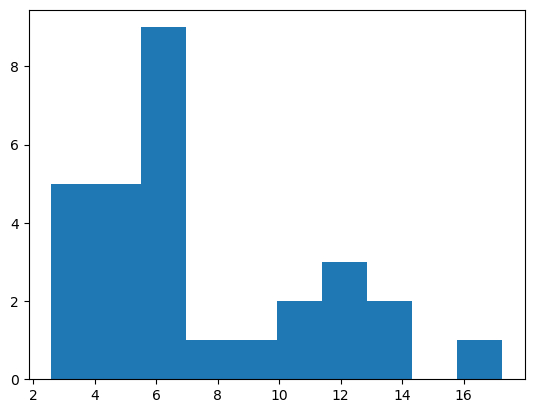

In [262]:
df5 = df[df.Dilution == '10^(-5)']
df6 = df[df.Dilution == '10^(-6)']

plt.hist(df5['wave_speed_av'], bins=10)
plt.show()
plt.hist(df6['wave_speed_av'], bins=10)
plt.show()

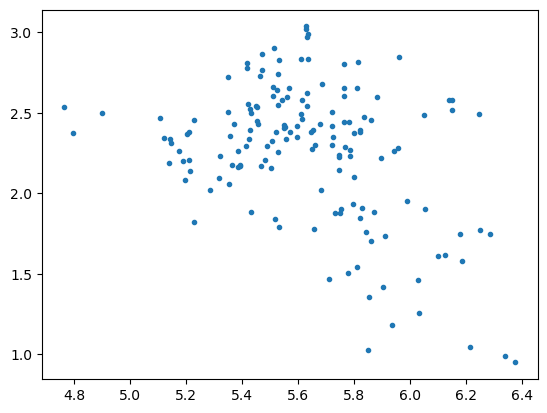

In [264]:
plt.plot(np.log(df['rad_max_um']), np.log(df['wave_speed_av']),'.')

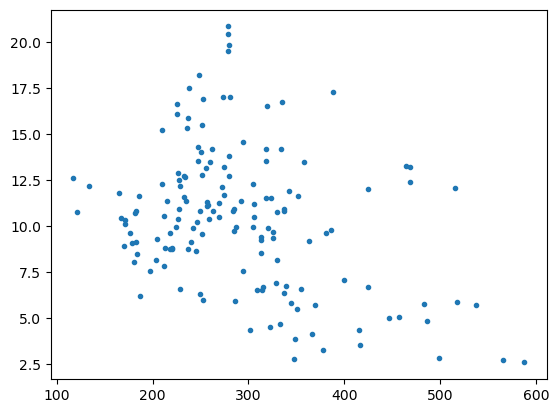

In [266]:
plt.plot(df['rad_max_um'],df['wave_speed_av'],'.')

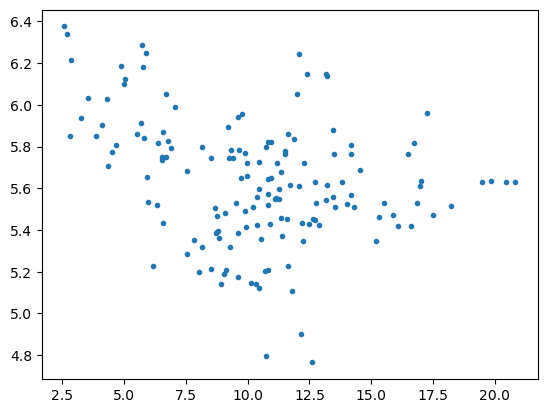

In [267]:
plt.plot(df['wave_speed_av'], np.log(df['rad_max_um']),'.')

(array([10., 14., 15., 27., 38., 25.,  9.,  9.,  3.,  4.]),
 array([ 2.5861477 ,  4.41013752,  6.23412735,  8.05811717,  9.88210699,
        11.70609681, 13.53008663, 15.35407645, 17.17806627, 19.00205609,
        20.82604591]),
 <BarContainer object of 10 artists>)

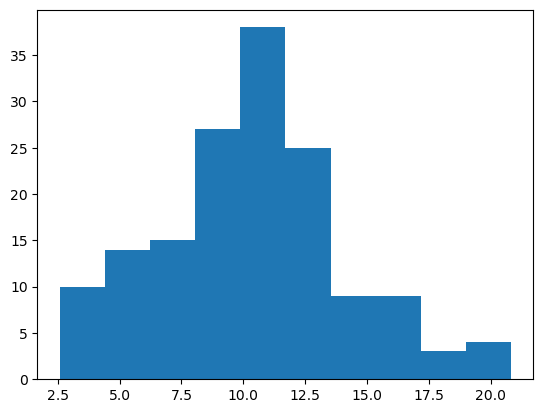

In [268]:
plt.hist(df['wave_speed_av'], bins=10)

In [ ]:
plt.imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
            aspect='auto', 
            extent=[t0,nt,-edt.max(),edt.max()],
            vmin=-0.1, vmax=0.1,
            cmap='jet')

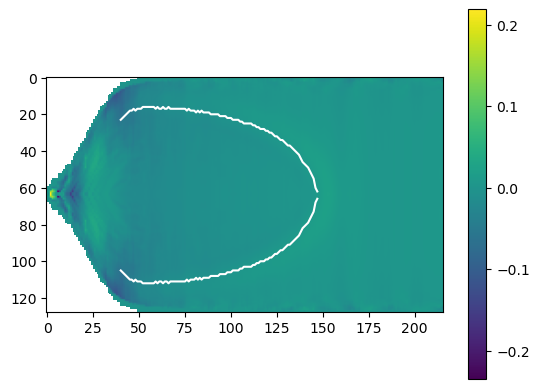

In [523]:
data = np.hstack([wdlkymo_rho[:,::-1],wdlkymo_rho[:,:]]).transpose()
sy, _ = data.shape
plt.imshow(data)
plt.plot(rads,'w')
plt.plot(-rads+sy,'w')
plt.colorbar()
plt.show()